# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [116]:
import pandas as pd  # import the neccessary libraries
pd.set_option('display.max_columns', 300)  # display all the columns
pd.set_option('display.max_rows', 100)
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import pickle
from sklearn.neighbors import KNeighborsRegressor  # In case we want to use k-nearest neighbor model
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


plt.style.use('seaborn')
sns.set(style="white")

In [117]:
df = pd.read_csv('kc_house_data_train.csv')# read in the csv file with train data
#zip_df = pd.read_csv('zip_code_extra_data.csv')
print(df.shape)  # check the dimensions of the model
df.head()   # print the first 5 rows

(17290, 22)


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [118]:
##### Merge Zipcode Data #####

#df = pd.merge(df,zip_df,on='zipcode')
#df.shape

#### Drop Duplicates, keeping most recent sold ####
df['year_sold'] = df['date'].str[0:4].astype(int)
#df = df.sort_values(by=['year_sold']).drop_duplicates(['id'],keep='last')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.shape

(17290, 22)

In [120]:
#### Dropping columns I dont intend to Use ####
#df.drop(columns=['full_time_earnings','part_time_earnings','no_earnings','car_truck_van',
                 'public_transportation','taxi','motorcycle',
       'bike_walk_other', 'work_home', 'less_than_hs', 'high_school_grad',
       'associates', 'bachelors', 'masters', 'professional_school_degree',
       'doctorate', 'public_school_enrollment', 'private_school_enrollment',
       'no_school_enrollment', 'for_rent', 'rented_and_unoccupied',
       'for_sale_only', 'sold_and_unoccupied', 'seasonal_or_rec_use',
       'migrant_worker_housing', 'vacant_other_reasons',
       'in_occupied_housing_units', 'adult_correctional_facility',
       'juvenile_facilities', 'nursing_facilities', 'other_institutional',
       'military_quarters', 'other_noninstitutional',
       'house_owned_with_mortgage', 'house_owned_outright',
       'renter_occupied_housing', 'vacant_households',
       'husband_and_wife_house', 'single_guardian', 'singles',
       'singles_with_roommate', 'male', 'female','male_median_age', 'female_median_age',
         'total_housing_units','land_area', 'water_area_sq_mile',
       'occupied_housing_units'], inplace=True)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

In [121]:
#### Try bring down price extreme values ####

#IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
#upper_limit = df.price.quantile(0.75) + (IQR * 1.5)
#upper_limit_extreme = df.price.quantile(0.75) + (IQR * 10)
#df['price'] = np.where(df['price'] > upper_limit_extreme, upper_limit, df['price'])

In [122]:
##### Initial Data Cleaning -- Based Mostly off Abnormal Values

#Add column bath/bed
df['bath_per_bed'] = np.where(df['bedrooms'] > 0, df['bathrooms'] / df['bedrooms'], 0)
df.drop(columns=['bathrooms'], inplace=True)

#Add Log_Price
df['log_price'] = np.where(df['price'], np.log(df['price']), df['price'])

#Condesing 33 and 11 Bedroom values to 10
df['bedrooms'] = np.where(df['bedrooms'] > 10, 3, df['bedrooms'])
#House with 0 bedrooms to the Mean Bedrooms
df['bedrooms'] = np.where(df['bedrooms'] == 0, 3, df['bedrooms'])


##### Convert Date to Year_Sold and Month_Sold ####

df['year_sold'] = df['date'].str[0:4].astype(int)
df['month_sold'] = df['date'].str[4:6].astype(int)
df.drop(columns=['date'], inplace=True)

#### Drop Duplicates, keeping the most recent sale of house ####
#df = df.sort_values(by=['year_sold']).drop_duplicates(['id'],keep='last')

#### Floors seems to not be very significant, converting to binary (0 = 1 Floor, 1 = Multi-Floors)
df['floors'] = np.where(df['floors'] > 1, 1, 0)

In [123]:
#####Initial Data Cleaning -- Based Mostly off Multicolliniarity

#Drop 'sqft_above' column
df.drop(columns=['sqft_above'], inplace=True)

#Turn 'sqft_basement' into binary "Basement" column
df['basement'] = np.where(df['sqft_basement'] > 0, 1, 0)

#Drop 'sqft_basement' column
df.drop(columns=['sqft_basement'], inplace=True)
df.drop(columns=['sqft_living15'], inplace=True)

In [124]:
##### Zip Codes to Bins #####

price_by_zip = df.groupby('zipcode')['price'].mean().sort_values(ascending=False)
zip_category = pd.cut(price_by_zip, bins =[0,350000,600000,900000,3500000], labels = ['low','medium','high','very_high'])
df['zip_price_level'] = df['zipcode'].apply(lambda x: zip_category.loc[x])
df['zip_price_level'].value_counts()
df = pd.get_dummies(df, columns = ['zip_price_level'], drop_first= True)

In [125]:
##### Add Season column #####

def to_season(x):
    if x == 12 or x == 1 or x == 2:
        return 'cold_month'
    elif x == 3 or x == 4 or x == 5:
        return "warm_month"
    elif x == 6 or x == 7 or x == 8:
        return "warm_month"
    else:
        return 'cold_month'
df['season_sold'] = df['month_sold'].apply(to_season)

##### Get Dummies for Season & Year Sold Columns#####
df = pd.get_dummies(df, columns = ['season_sold'], drop_first= True)
df = pd.get_dummies(df, columns = ['year_sold'], drop_first= True)

#### Drop Uneeded Columns #####
df.drop(columns=['month_sold'], inplace=True)


In [126]:
##### Create Years Old Bins #####
df['age'] = 2020 - df['yr_built']
df.drop(columns=['yr_built'], inplace=True)
bins = [-2,25,50,100,100000]
labels = ['1','2','3','4']
df['age'] = pd.cut(df['age'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns = ['age'], drop_first= True)

##### Create Years since Renovation Column #####
# After EDA showed most houses havent been renovated, changing to binary
df['renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)
df.drop(columns=['yr_renovated'], inplace=True)

In [127]:
##### Create Number of Bedrooms #####

bed_bins = [-1,2,3,5,100]
bed_labels = ['1','2','3','4']
df['bedrooms'] = pd.cut(df['bedrooms'], bins=bed_bins, labels=bed_labels)
df = pd.get_dummies(df, columns = ['bedrooms'], drop_first= True)

In [128]:
##### Get Dummies for Other Categorical Variables #####

def sep_grade(x):
    if x == 13:
        return 'high'
    elif x == 10 or x == 11 or x == 11:
        return "medium"
    else:
        return 'low'
df['grade'] = df['grade'].apply(sep_grade)
df = pd.get_dummies(df, columns = ['grade'], drop_first= True)
## Grade not a great determinant of Price

#Turn condition into binary (Good Condition = 1, Bad Condition = 0)
df['condition'] = np.where(df['condition'] > 2, 1, 0)

df = pd.get_dummies(df, columns = ['view'], drop_first= True)

In [129]:
df.describe()
df.shape

(17290, 32)

In [130]:
df.dtypes

id                             int64
price                        float64
sqft_living                    int64
sqft_lot                       int64
floors                         int64
waterfront                     int64
condition                      int64
zipcode                        int64
lat                          float64
long                         float64
sqft_lot15                     int64
bath_per_bed                 float64
log_price                    float64
basement                       int64
zip_price_level_low            uint8
zip_price_level_medium         uint8
zip_price_level_very_high      uint8
season_sold_warm_month         uint8
year_sold_2015                 uint8
age_2                          uint8
age_3                          uint8
age_4                          uint8
renovated                      int64
bedrooms_2                     uint8
bedrooms_3                     uint8
bedrooms_4                     uint8
grade_low                      uint8
g

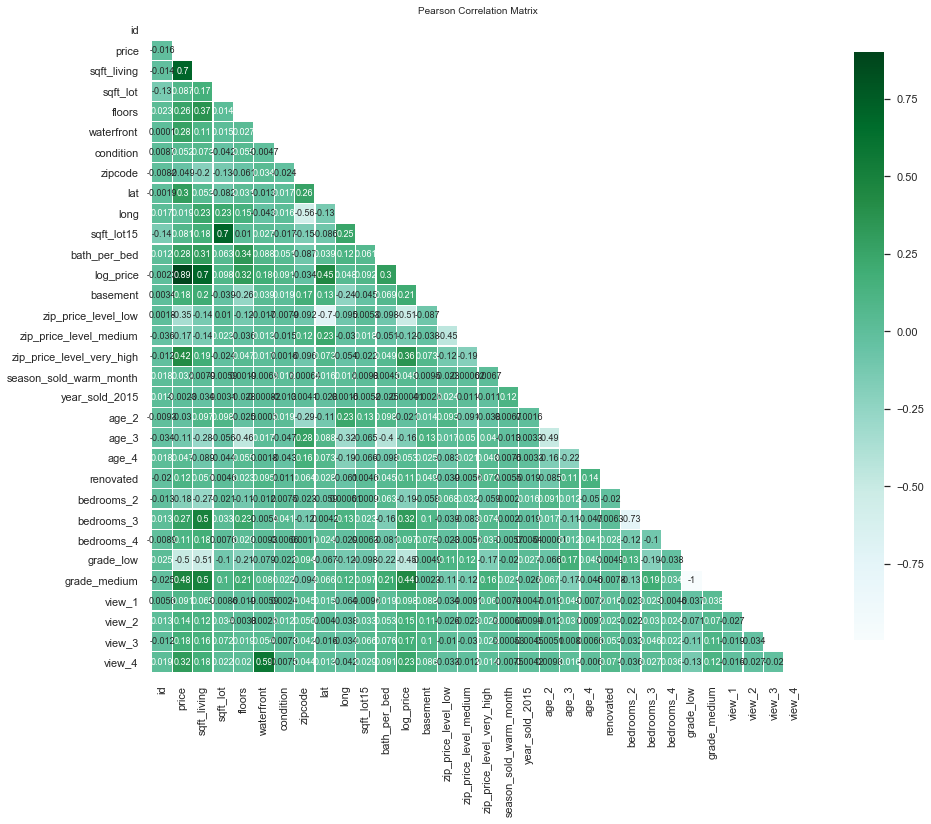

In [131]:
# Checking the correlation between the features
mask = np.zeros_like(df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.savefig("pearson.png")
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(df.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()


### Notes: 
All the sqft variables seem to have a very high correlation. Should think about dropping

Some columns useful for EDA but not Modelling
    
    Price & Log_Price
    yr_renovated & yr_since_renovated


### Below code evaluates VIF

In [132]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices

In [133]:

features = "+".join(df.columns)
features = features.replace('price+', '', 1)
features = features.replace('log_price+', '', 1)
features = features.replace('date+', '', 1)
features = features.replace('id+', '', 1)

y, X = dmatrices('price~' + features, df, return_type='dataframe')

In [134]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [135]:
vif.sort_values(by = "VIF_Factor",ascending=False).head(10)

,VIF_Factor,features
0,4.421287e+06,Intercept
24,1.089168e+02,grade_low
25,1.066846e+02,grade_medium
22,4.907923e+00,bedrooms_3
1,3.240358e+00,sqft_living
21,3.059464e+00,bedrooms_2
18,3.056110e+00,age_3
12,2.916192e+00,zip_price_level_low
7,2.308328e+00,lat
10,2.108343e+00,bath_per_bed


VIF Notes: 
    
    VIF score of 'inf' means these variables show almost perfect correlation. Which proves that sqft variables show 
    multicollinearity
    
    VIF < 3 is ideal. VIF < 10 is sufficient

In [136]:
##### OLS Regression Model #####
features_df = df.drop(columns=['id', 'price','log_price'])
str_features_col= "+".join(features_df)
mlr_model = smf.ols(formula=f'price~{str_features_col}', data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     2043.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:59:50   Log-Likelihood:            -2.3350e+05
No. Observations:               17290   AIC:                         4.671e+05
Df Residuals:                   17260   BIC:                         4.673e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.831e+07   2.84e+06     -6.453      0.000   -2.39e+07   -1.28e+07
sqft_living                 216.6726      2.641     82.047      0.000     211.496     221.849
sqft_lot                      0.2578      0.045      5.705      0.000       0.169       0.346
floors                    -2603.5446   3727.838     -0.698      0.485   -9910.484    4703.395
waterfront                 5.338e+05   1.89e+04     28.226      0.000    4.97e+05    5.71e+05
condition                  3.797e+04   1.41e+04      2.697      0.007    1.04e+04    6.56e+04
zipcode                    -322.2238     32.973     -9.772      0.000    -386.853    -257.594
lat                        3.338e+05   1.48e+04     22.532      0.000    3.05e+05    3.63e+05
long                      -2.944e+05   1.32e+04    -22.224      0.000    -3.2e+05   -2.68e+05
sqft_lot15                   -0.1686      0.071     -2.379      0.017      -0.308      -0.030
bath_per_bed               5.216e+04   9185.729      5.678      0.000    3.42e+04    7.02e+04
basement                  -3.384e+04   3343.683    -10.121      0.000   -4.04e+04   -2.73e+04
zip_price_level_low       -2.055e+05   5581.769    -36.817      0.000   -2.16e+05   -1.95e+05
zip_price_level_medium    -1.271e+05   3353.115    -37.902      0.000   -1.34e+05   -1.21e+05
zip_price_level_very_high  3.808e+05   6987.293     54.503      0.000    3.67e+05    3.95e+05
season_sold_warm_month     1.322e+04   2774.078      4.767      0.000    7786.640    1.87e+04
year_sold_2015             2.504e+04   2913.259      8.595      0.000    1.93e+04    3.08e+04
age_2                     -1.948e+04   4134.540     -4.710      0.000   -2.76e+04   -1.14e+04
age_3                      2.357e+04   4812.662      4.897      0.000    1.41e+04     3.3e+04
age_4                       8.11e+04   6732.185     12.047      0.000    6.79e+04    9.43e+04
renovated                  3.395e+04   7055.719      4.812      0.000    2.01e+04    4.78e+04
bedrooms_2                -1.206e+04   4740.198     -2.544      0.011   -2.14e+04   -2768.373
bedrooms_3                -4.246e+04   6125.733     -6.932      0.000   -5.45e+04   -3.05e+04
bedrooms_4                 -8.34e+04    1.3e+04     -6.425      0.000   -1.09e+05    -5.8e+04
grade_low                 -1.863e+06   5.49e+04    -33.918      0.000   -1.97e+06   -1.76e+06
grade_medium              -1.704e+06   5.46e+04    -31.217      0.000   -1.81e+06    -1.6e+06
view_1                     9.489e+04   1.12e+04      8.499      0.000     7.3e+04    1.17e+05
view_2                     9.546e+04   6695.754     14.257      0.000    8.23e+04    1.09e+05
view_3                     1.603e+05   9181.289     17.457      0.000    1.42e+05    1.78e+05
view_4                     3.481e+05   1.38e+04     25.226      0.000    3.

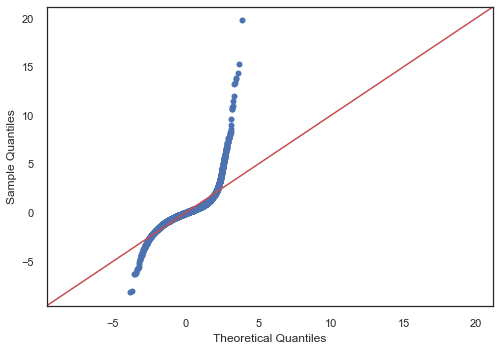

In [137]:
fig = sm.graphics.qqplot(mlr_model.resid, dist=stats.norm, line='45', fit=True)

In [138]:
features_df = df.drop(columns=['id', 'price','log_price','sqft_lot15','zipcode'])
str_features_col= "+".join(features_df)
mlr_model = smf.ols(formula=f'log_price~{str_features_col}', data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     2809.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:59:52   Log-Likelihood:                 1115.2
No. Observations:               17290   AIC:                            -2174.
Df Residuals:                   17262   BIC:                            -1957.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -63.6725      1.864    -34.166      0.000     -67.325     -60.020
sqft_living                   0.0003   3.36e-06     78.953      0.000       0.000       0.000
sqft_lot                    6.54e-07    4.3e-08     15.194      0.000     5.7e-07    7.38e-07
floors                        0.0386      0.005      8.140      0.000       0.029       0.048
waterfront                    0.3657      0.024     15.117      0.000       0.318       0.413
condition                     0.2203      0.018     12.231      0.000       0.185       0.256
lat                           0.6661      0.019     35.614      0.000       0.629       0.703
long                         -0.3609      0.015    -23.666      0.000      -0.391      -0.331
bath_per_bed                  0.1882      0.012     16.030      0.000       0.165       0.211
basement                     -0.0148      0.004     -3.469      0.001      -0.023      -0.006
zip_price_level_low          -0.5020      0.007    -70.306      0.000      -0.516      -0.488
zip_price_level_medium       -0.2499      0.004    -58.288      0.000      -0.258      -0.242
zip_price_level_very_high     0.3463      0.009     39.269      0.000       0.329       0.364
season_sold_warm_month        0.0252      0.004      7.104      0.000       0.018       0.032
year_sold_2015                0.0411      0.004     11.040      0.000       0.034       0.048
age_2                        -0.0163      0.005     -3.103      0.002      -0.027      -0.006
age_3                         0.0071      0.006      1.152      0.249      -0.005       0.019
age_4                         0.0956      0.009     11.111      0.000       0.079       0.112
renovated                     0.0477      0.009      5.288      0.000       0.030       0.065
bedrooms_2                    0.0766      0.006     12.668      0.000       0.065       0.088
bedrooms_3                    0.1016      0.008     13.016      0.000       0.086       0.117
bedrooms_4                    0.0163      0.017      0.986      0.324      -0.016       0.049
grade_low                     0.0786      0.070      1.119      0.263      -0.059       0.216
grade_medium                  0.1920      0.070      2.749      0.006       0.055       0.329
view_1                        0.1584      0.014     11.091      0.000       0.130       0.186
view_2                        0.1668      0.009     19.498      0.000       0.150       0.184
view_3                        0.2216      0.012     18.893      0.000       0.199       0.245
view_4                        0.3371      0.018     19.107      0.000       0.303       0.372
==============================================================================
Omnibus:                     1001.453   Durbin-Watson:                   2.015
Prob(Omnibu

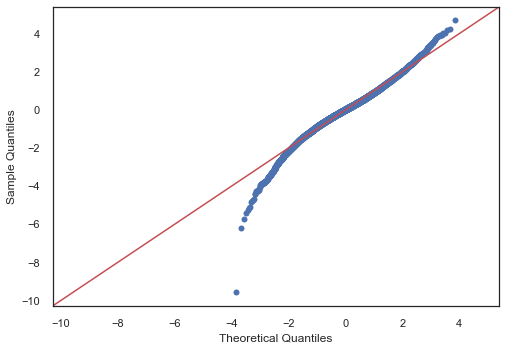

In [139]:
fig = sm.graphics.qqplot(mlr_model.resid, dist=stats.norm, line='45', fit=True)

# Model 1: Linear Model

In [140]:
features_df = df.drop(columns=['id', 'price','log_price','sqft_lot15','zipcode'])
target = df['price']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, random_state=9,test_size=0.25)

### 5.2) Fit your scaler to training the data.

In [142]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=features_df.columns)

### 5.3) Transform the testing set with the scaler.

In [143]:
#transform the testing data
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=features_df.columns)

### 5.4) Fit the model to the training data.

In [144]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 178395.93517116082


### 5.5) Use the model to predict on the training set and the test set.

In [145]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
lin_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(lin_test_rmse))
print("R^2: ", lm.score(features_df, target))

Testing Root Mean Squared Error: 186502.3033069708
Training:  178395 vs. Testing:  176741
R^2:  -3526025.151720706


### 5.6) Evaluate the training and test predictions using RMSE.

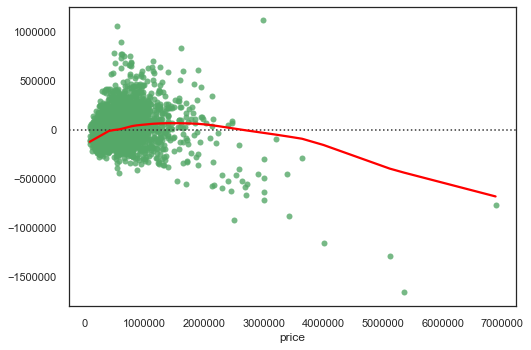

In [146]:
sns.residplot(y_test, y_test_pred, lowess=True, color="g", line_kws={"color": "red"});

# Model 1B: Linear w/ Recursive Feature Elimination

In [147]:
from sklearn.feature_selection import RFECV

In [148]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, random_state=9,test_size=0.2)

In [149]:
ols = linear_model.LinearRegression()

In [150]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=2, scoring='neg_mean_squared_error', n_jobs=-1,verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=2,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [151]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [152]:
print(len(list(selected_rfe)))
list(selected_rfe)

27


['sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'lat',
 'long',
 'bath_per_bed',
 'basement',
 'zip_price_level_low',
 'zip_price_level_medium',
 'zip_price_level_very_high',
 'season_sold_warm_month',
 'year_sold_2015',
 'age_2',
 'age_3',
 'age_4',
 'renovated',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'grade_low',
 'grade_medium',
 'view_1',
 'view_2',
 'view_3',
 'view_4']

In [153]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)
print("R^2: ", lm_rfe.score(features_df[selected_rfe], target))

Training Root Mean Squared Error: 178771.09678362487
Testing Root Mean Squared Error: 174768.11962347702
R^2:  0.7727017034097969


In [54]:
df[selected_rfe].head()

,sqft_living,sqft_lot,floors,waterfront,condition,lat,long,bath_per_bed,basement,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,season_sold_warm_month,year_sold_2015,age_2,age_3,age_4,renovated,bedrooms_2,bedrooms_3,bedrooms_4,grade_low,grade_medium,view_1,view_2,view_3,view_4
0,2070,8893,1,0,1,47.4388,-122.162,0.562500,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
1,2900,6730,0,0,1,47.6784,-122.285,0.600000,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0
2,3770,10893,1,0,1,47.5646,-122.129,0.625000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,4560,14608,1,0,1,47.6995,-122.228,1.166667,0,0,1,0,1,1,1,0,0,0,1,0,0,1,0,0,1,0,0
4,2550,5376,1,0,1,47.6647,-122.083,0.833333,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


# Model 2: Polynomial Model

In [205]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(features_df)
poly2_columns = poly_2.get_feature_names(features_df.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(17290, 405)


,sqft_living,sqft_lot,floors,waterfront,condition,lat,long,bath_per_bed,basement,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,season_sold_warm_month,year_sold_2015,age_2,age_3,age_4,renovated,bedrooms_2,bedrooms_3,bedrooms_4,grade_low,grade_medium,view_1,view_2,view_3,view_4,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living waterfront,sqft_living condition,sqft_living lat,sqft_living long,sqft_living bath_per_bed,sqft_living basement,sqft_living zip_price_level_low,sqft_living zip_price_level_medium,sqft_living zip_price_level_very_high,sqft_living season_sold_warm_month,sqft_living year_sold_2015,sqft_living age_2,sqft_living age_3,sqft_living age_4,sqft_living renovated,sqft_living bedrooms_2,sqft_living bedrooms_3,sqft_living bedrooms_4,sqft_living grade_low,sqft_living grade_medium,sqft_living view_1,sqft_living view_2,sqft_living view_3,sqft_living view_4,sqft_lot^2,sqft_lot floors,sqft_lot waterfront,sqft_lot condition,sqft_lot lat,sqft_lot long,sqft_lot bath_per_bed,sqft_lot basement,sqft_lot zip_price_level_low,sqft_lot zip_price_level_medium,sqft_lot zip_price_level_very_high,sqft_lot season_sold_warm_month,sqft_lot year_sold_2015,sqft_lot age_2,sqft_lot age_3,sqft_lot age_4,sqft_lot renovated,sqft_lot bedrooms_2,sqft_lot bedrooms_3,sqft_lot bedrooms_4,sqft_lot grade_low,sqft_lot grade_medium,sqft_lot view_1,sqft_lot view_2,sqft_lot view_3,sqft_lot view_4,floors^2,floors waterfront,floors condition,floors lat,floors long,floors bath_per_bed,floors basement,floors zip_price_level_low,floors zip_price_level_medium,floors zip_price_level_very_high,floors season_sold_warm_month,floors year_sold_2015,floors age_2,floors age_3,floors age_4,floors renovated,floors bedrooms_2,floors bedrooms_3,floors bedrooms_4,floors grade_low,floors grade_medium,floors view_1,floors view_2,floors view_3,floors view_4,waterfront^2,waterfront condition,waterfront lat,waterfront long,waterfront bath_per_bed,waterfront basement,waterfront zip_price_level_low,waterfront zip_price_level_medium,waterfront zip_price_level_very_high,waterfront season_sold_warm_month,waterfront year_sold_2015,waterfront age_2,waterfront age_3,waterfront age_4,waterfront renovated,waterfront bedrooms_2,waterfront bedrooms_3,waterfront bedrooms_4,waterfront grade_low,waterfront grade_medium,waterfront view_1,waterfront view_2,waterfront view_3,waterfront view_4,condition^2,condition lat,condition long,condition bath_per_bed,condition basement,condition zip_price_level_low,condition zip_price_level_medium,condition zip_price_level_very_high,condition season_sold_warm_month,condition year_sold_2015,condition age_2,condition age_3,condition age_4,condition renovated,condition bedrooms_2,condition bedrooms_3,condition bedrooms_4,condition grade_low,condition grade_medium,condition view_1,condition view_2,...,zip_price_level_medium year_sold_2015,zip_price_level_medium age_2,zip_price_level_medium age_3,zip_price_level_medium age_4,zip_price_level_medium renovated,zip_price_level_medium bedrooms_2,zip_price_level_medium bedrooms_3,zip_price_level_medium bedrooms_4,zip_price_level_medium grade_low,zip_price_level_medium grade_medium,zip_price_level_medium view_1,zip_price_level_medium view_2,zip_price_level_medium view_3,zip_price_level_medium view_4,zip_price_level_very_high^2,zip_price_level_very_high season_sold_warm_month,zip_price_level_very_high year_sold_2015,zip_price_level_very_high age_2,zip_price_level_very_high age_3,zip_price_level_very_high age_4,zip_price_level_very_high renovated,zip_price_level_very_high bedrooms_2,zip_price_level_very_high bedrooms_3,zip_price_level_very_high bedrooms_4,zip_price_level_very_high grade_low,zip_price_level_very_high grade_medium,zip_price_level_very_high view_1,zip_price_level_very_high view_2,zip_price_level_very_high view_3,zip_price_level_very_high view_4,season_sold_warm_month^2,season_sold_warm_month year_sold_2015,season_sold_warm_month age_2,season_sold_warm_month age_3,season_so

In [206]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=9,test_size=0.2)

In [207]:
scaler2 = StandardScaler()
# fit the scaler to the training data
scaler2.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [208]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 131596.97308668707


In [209]:
y_pred = lm_2.predict(X_test)

poly_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(poly_test_rmsee))

Testing Root Mean Squared Error: 183320.80226404002


NameError: name 'poly_test_rmsee' is not defined

In [210]:
print("R^2: ", lm_2.score(df_poly2, target))

R^2:  -8.034838522095454e+25


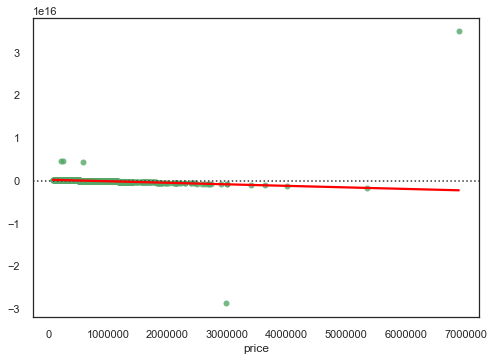

In [182]:
sns.residplot(y_test, y_pred, lowess=True, color="g", line_kws={"color": "red"});

# Model 2A: Polynomial + RFE Model

In [161]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=2, cv=7, scoring='neg_mean_squared_error', n_jobs=-1,verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

Fitting estimator with 405 features.
Fitting estimator with 403 features.
Fitting estimator with 401 features.
Fitting estimator with 399 features.
Fitting estimator with 397 features.
Fitting estimator with 395 features.
Fitting estimator with 393 features.
Fitting estimator with 391 features.
Fitting estimator with 389 features.
Fitting estimator with 387 features.
Fitting estimator with 385 features.
Fitting estimator with 383 features.
Fitting estimator with 381 features.
Fitting estimator with 379 features.
Fitting estimator with 377 features.
Fitting estimator with 375 features.
Fitting estimator with 373 features.
Fitting estimator with 371 features.
Fitting estimator with 369 features.
Fitting estimator with 367 features.
Fitting estimator with 365 features.
Fitting estimator with 363 features.
Fitting estimator with 361 features.
Fitting estimator with 359 features.
Fitting estimator with 357 features.
Fitting estimator with 355 features.
Fitting estimator with 353 features.
F

RFECV(cv=7,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=2, verbose=1)

In [169]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [170]:
print(list(selected_rfe))

['sqft_living']


In [174]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data

lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


train_poly_RFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , train_poly_RFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

test_poly_RFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , test_poly_RFE_rmse)


Training Root Mean Squared Error: 267853.0316828937
Testing Root Mean Squared Error: 254808.0246028645


# Model 3: Lasso + Polynomial

In [184]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training Error: '+ str(train_rmse_lasso01) )
print('Testing Error: '+ str(test_rmse_lasso01) )
print("R^2: ", lasso.score(df_poly2, target))

Training Error: 88748.18165154556
Testing Error: 142415.79821081518
R^2:  -3.6301202869630355e+17


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137947509032881.8, tolerance: 194982925380.51126
  positive)


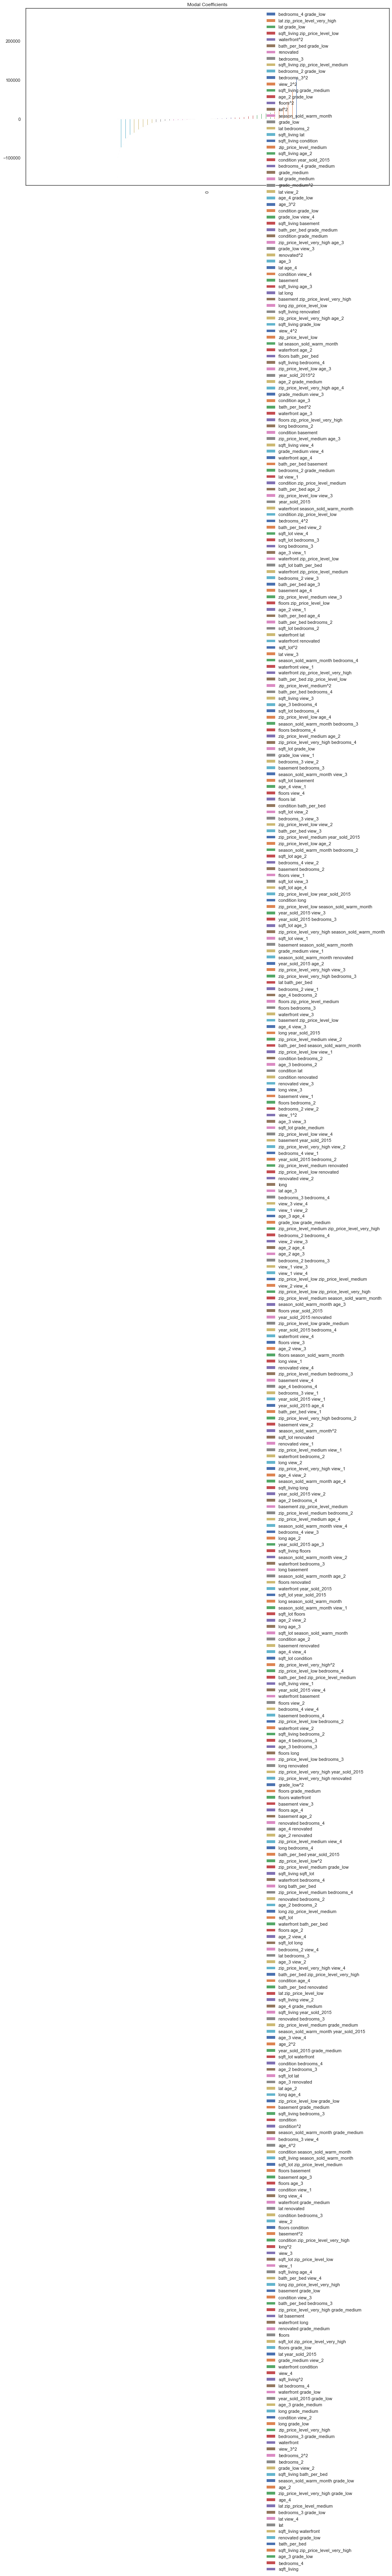

In [185]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,8))

# Final Model: KBest + Polynomial

In [186]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=30)

selector.fit(X_train, y_train)

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=30, score_func=<function f_regression at 0x7ff7d2eb20e0>)

In [187]:
kb_selected_columns = X_train.columns[selector.get_support()]
kb_removed_columns = X_train.columns[~selector.get_support()]

In [188]:
list(kb_removed_columns)


['sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'lat',
 'long',
 'bath_per_bed',
 'basement',
 'zip_price_level_low',
 'zip_price_level_medium',
 'season_sold_warm_month',
 'year_sold_2015',
 'age_2',
 'age_3',
 'age_4',
 'renovated',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'sqft_living sqft_lot',
 'sqft_living waterfront',
 'sqft_living basement',
 'sqft_living zip_price_level_low',
 'sqft_living zip_price_level_medium',
 'sqft_living season_sold_warm_month',
 'sqft_living year_sold_2015',
 'sqft_living age_2',
 'sqft_living age_3',
 'sqft_living age_4',
 'sqft_living renovated',
 'sqft_living bedrooms_2',
 'sqft_living bedrooms_4',
 'sqft_living grade_low',
 'sqft_living view_1',
 'sqft_living view_2',
 'sqft_living view_3',
 'sqft_living view_4',
 'sqft_lot^2',
 'sqft_lot floors',
 'sqft_lot waterfront',
 'sqft_lot condition',
 'sqft_lot lat',
 'sqft_lot long',
 'sqft_lot bath_per_bed',
 'sqft_lot basement',
 'sqft_lot zip_pric

In [189]:
list(kb_selected_columns)

['sqft_living',
 'zip_price_level_very_high',
 'grade_low',
 'grade_medium',
 'sqft_living^2',
 'sqft_living floors',
 'sqft_living condition',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living bath_per_bed',
 'sqft_living zip_price_level_very_high',
 'sqft_living bedrooms_3',
 'sqft_living grade_medium',
 'sqft_lot zip_price_level_very_high',
 'floors grade_medium',
 'condition zip_price_level_very_high',
 'condition grade_low',
 'condition grade_medium',
 'lat zip_price_level_very_high',
 'lat grade_low',
 'lat grade_medium',
 'long zip_price_level_very_high',
 'long grade_low',
 'long grade_medium',
 'bath_per_bed zip_price_level_very_high',
 'bath_per_bed grade_medium',
 'zip_price_level_very_high^2',
 'bedrooms_3 grade_medium',
 'grade_low^2',
 'grade_medium^2']

In [190]:
df_poly2[(kb_selected_columns)].columns

Index(['sqft_living', 'zip_price_level_very_high', 'grade_low', 'grade_medium',
       'sqft_living^2', 'sqft_living floors', 'sqft_living condition',
       'sqft_living lat', 'sqft_living long', 'sqft_living bath_per_bed',
       'sqft_living zip_price_level_very_high', 'sqft_living bedrooms_3',
       'sqft_living grade_medium', 'sqft_lot zip_price_level_very_high',
       'floors grade_medium', 'condition zip_price_level_very_high',
       'condition grade_low', 'condition grade_medium',
       'lat zip_price_level_very_high', 'lat grade_low', 'lat grade_medium',
       'long zip_price_level_very_high', 'long grade_low', 'long grade_medium',
       'bath_per_bed zip_price_level_very_high', 'bath_per_bed grade_medium',
       'zip_price_level_very_high^2', 'bedrooms_3 grade_medium', 'grade_low^2',
       'grade_medium^2'],
      dtype='object')

In [191]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2[(kb_selected_columns)], target, random_state=9,test_size=0.25)

In [192]:
f_scaler = StandardScaler()

# fit the scaler to the training data
f_scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=f_scaler.transform(X_train), columns=df_poly2[(kb_selected_columns)].columns)

In [193]:
#transform the testing data
X_test = pd.DataFrame(data=f_scaler.transform(X_test), columns=df_poly2[(kb_selected_columns)].columns)

In [194]:
#instantiate a linear regression object
f_lm = LinearRegression()

#fit the linear regression to the data
f_lm = f_lm.fit(X_train, y_train)

y_train_pred = f_lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 191513.63129126088


In [195]:
#use fitted model to predict on the test examples
y_test_pred = f_lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 183320.80226404002
Training:  191513 vs. Testing:  183320


In [196]:
print("R^2: ", f_lm.score(df_poly2[(kb_selected_columns)], target))

R^2:  -270278882193597.12


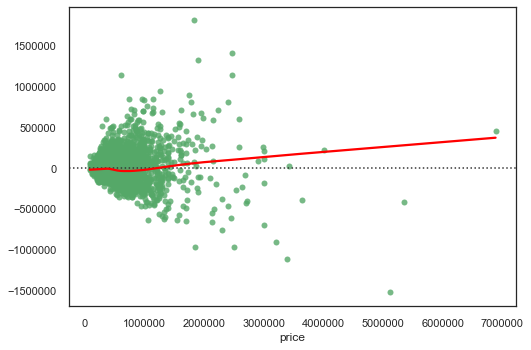

In [197]:
sns.residplot(y_test, y_test_pred, lowess=True, color="g", line_kws={"color": "red"});

In [198]:
print('Original: \t',   lin_test_rmse, '\n',
      'Lin_RFE:  \t', testRFE_rmse, '\n',
      'Poly:  \t',      poly_test_rmse, '\n',
      'Poly RFE:   \t', test_poly_RFE_rmse, '\n'
      'KBest:   \t',    testK_rmse, '\n',
      'Lasso 0.01: \t',  test_rmse_lasso01, '\n')

NameError: name 'poly_test_rmse' is not defined

### Negative R-Squared:       
It is possible to get a negative R-square for equations that do not contain a constant term. Because R-square is defined as the proportion of variance explained by the fit, if the fit is actually worse than just fitting a horizontal line then R-square is negative.

### 5.7) Determine if your model is overfit.

In [434]:
import pickle

pickle_out = open('model.pickle','wb')
pickle.dump(lm_2, pickle_out)
pickle_out.close()

In [435]:
import pickle

pickle_out = open("scaler.pickle","wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()